# Obtaining Learning curves for programming language in Stackoverflow

In [75]:
#Import Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Import Tables

In [76]:
RanswersTable = pd.read_csv("r_answers.csv")
RquestionsTable = pd.read_csv("r_questions.csv")
JAVAanswersTable = pd.read_csv("java_answers.csv",error_bad_lines=False)
JAVAquestionsTable = pd.read_csv("java_questions.csv",error_bad_lines=False)
PYTanswersTable = pd.read_csv("python_answers.csv",error_bad_lines=False)
PYTquestionsTable=pd.read_csv("python_questions.csv",error_bad_lines=False)

C:\Users\baren\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
b'Skipping line 1122646: expected 7 fields, saw 12\n'
b'Skipping line 325621: expected 10 fields, saw 23\n'
b'Skipping line 336660: expected 10 fields, saw 74\nSkipping line 366638: expected 10 fields, saw 19\n'
b'Skipping line 455722: expected 10 fields, saw 11\n'
b'Skipping line 804123: expected 10 fields, saw 19\n'
b'Skipping line 865079: expected 10 fields, saw 12\nSkipping line 866131: expected 10 fields, saw 15\n'


## Task 1 - Compute Probabilities of answers getting accpeted for each users at several time points.

In [77]:
def addProbAcceptedAnswerToTable(answersTable_provided,questionsTable_provided):
    
    answersTable=answersTable_provided.copy()
    questionsTable=questionsTable_provided.copy()
    answersTable=answersTable.sort_values([' OwnerUserId',' CreationDate']) #order by user and then by creation date
    questionsTable=questionsTable.sort_values([' OwnerUserId',' CreationDate']) #order by user and then by creation date
    
    #Find answers that were accepted (note that this information is in questions table)
    accepted=pd.match(answersTable["Id"].tolist(),questionsTable[' AcceptedAnswerId'])
    
    #Update answersTable with infor regarding whether answer was the accepted one or not.
    answersTable["AcceptedAnswer"]=accepted
    answersTable['AcceptedAnswer'] = np.where(answersTable['AcceptedAnswer'] == -1,0, answersTable['AcceptedAnswer'])
    answersTable['AcceptedAnswer'] = np.where(answersTable['AcceptedAnswer'] != 0,1, answersTable['AcceptedAnswer'])
    
    #Compute cumulative sum of accepted answers so far.
    answersTable['CumSumAccepted'] = answersTable.groupby(' OwnerUserId')['AcceptedAnswer'].cumsum()

    #Compute number of questions answered so far.
    answersTable['CumSumQuestions'] = answersTable.groupby(' OwnerUserId').cumcount() + 1

    #Compute prob of accepted answer
    answersTable['ProbAccAnswer'] = answersTable['CumSumAccepted']/answersTable['CumSumQuestions']
    
    return(answersTable)
 

In [78]:
#Compute probabilities of answer getting accepted for R, JAVA and Python
RanswersTable = addProbAcceptedAnswerToTable(RanswersTable,RquestionsTable)
JAVAanswersTable = addProbAcceptedAnswerToTable(JAVAanswersTable,JAVAquestionsTable)
PYTanswersTable = addProbAcceptedAnswerToTable(PYTanswersTable,PYTquestionsTable)

#Make sure that questions table is also sorted
RquestionsTable=RquestionsTable.sort_values([' OwnerUserId',' CreationDate']) #order by user and then by creation date
JAVAquestionsTable=JAVAquestionsTable.sort_values([' OwnerUserId',' CreationDate']) #order by user and then by creation date
PYTquestionsTable = PYTquestionsTable.sort_values([' OwnerUserId',' CreationDate']) #order by user and then by creation date

C:\Users\baren\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: pd.match() is deprecated and will be removed in a future version
  if __name__ == '__main__':


## Task2 - Identify First Activity for each User

In [79]:
def formatCreationDateColumn(table_provided):
    table = table_provided.copy()
    
   
    #Correcting format of dates in the table
    table[' CreationDate']=pd.to_datetime(table[' CreationDate'],errors="coerce")
    
    #remove lines which could not be formatted to correct date format
    table=table.loc[~table[" CreationDate"].isnull()]
    
    return(table)

In [80]:
RanswersTable = formatCreationDateColumn(RanswersTable)
JAVAanswersTable = formatCreationDateColumn(JAVAanswersTable)
PYTanswersTable = formatCreationDateColumn(PYTanswersTable)

RquestionsTable = formatCreationDateColumn(RquestionsTable)
JAVAquestionsTable = formatCreationDateColumn(JAVAquestionsTable)
PYTquestionsTable = formatCreationDateColumn(PYTquestionsTable)

In [81]:
def gettingTableUserFirstActivity(answersTable_provided,questionsTable_provided):
    answersTable = answersTable_provided.copy()
    questionsTable = questionsTable_provided.copy()
    
    #"Normalization": 0 should correspond to time of first activity so that time is read as days after first activity
    #identify the first activity of users
    answersTable["FirstActivity"]=~answersTable[" OwnerUserId"].duplicated()
    questionsTable["FirstActivity"]=~questionsTable[" OwnerUserId"].duplicated()
    
    #obtaining first answer and first question of a user
    firstAnswers=answersTable.loc[answersTable["FirstActivity"]==True][[" OwnerUserId"," CreationDate"]]
    firstQuestions = questionsTable.loc[questionsTable["FirstActivity"]==True][[" OwnerUserId"," CreationDate"]]
    
    #and merge them into one table
    firstActTable=firstQuestions.merge(firstAnswers, left_on=" OwnerUserId", right_on=" OwnerUserId", how='outer')
    firstActTable.columns = [" OwnerUserId","FirstQuestion","FirstAnswer"]
    
    #obtain first activity (either answer or question)
    firstActTable["FirstActivity"]=firstActTable[["FirstQuestion","FirstAnswer"]].min(axis=1)
    
    return(firstActTable)

In [82]:
RfirstActTable = gettingTableUserFirstActivity(RanswersTable,RquestionsTable)
JAVAfirstActTable = gettingTableUserFirstActivity(JAVAanswersTable,JAVAquestionsTable)
PYTfirstActTable = gettingTableUserFirstActivity(PYTanswersTable,PYTquestionsTable)

In [83]:
RfirstActTable

,OwnerUserId,FirstQuestion,FirstAnswer,FirstActivity
0,0,2008-09-17 03:39:16.913,2008-09-17 03:51:30.190,2008-09-17 03:39:16.913
1,277,2008-09-24 13:31:07.500,2011-01-18 17:53:30.627,2008-09-24 13:31:07.500
2,280,2009-12-11 01:18:47.903,NaT,2009-12-11 01:18:47.903
3,337,2014-10-16 17:33:39.987,2014-08-19 19:58:00.707,2014-08-19 19:58:00.707
4,357,2016-03-04 15:00:16.023,NaT,2016-03-04 15:00:16.023
5,404,2010-01-23 00:30:05.610,NaT,2010-01-23 00:30:05.610
6,422,2009-05-18 08:16:10.573,NaT,2009-05-18 08:16:10.573
7,445,2009-01-31 14:50:28.677,2009-02-04 15:12:59.503,2009-01-31 14:50:28.677
8,572,2009-01-07 13:27:28.407,NaT,2009-01-07 13:27:28.407
9,681,2012-04-06 21:21:34.377,2012-10-01 22:57:01.570,2012-04-06 21:21:34.377


## Task 3 Obtain normalized time for x axis

In [84]:
def obtainSummaryProbAccAnswer(answersTable,questionsTable,firstActTable):
    
    #Adding first activity table to answerstable 
    summaryTableProbAccAnswer = answersTable[["Id"," OwnerUserId"," CreationDate"," ParentId","ProbAccAnswer"]]
    summaryTableProbAccAnswer=summaryTableProbAccAnswer.merge(firstActTable,left_on = " OwnerUserId",right_on=" OwnerUserId")
    
    #Use first activity to obtain normalized time
    summaryTableProbAccAnswer["Present"]= max(summaryTableProbAccAnswer[" CreationDate"])
    #timestamp of answer compared to first activity of that user
    summaryTableProbAccAnswer["DifferenceNumerator"]=(summaryTableProbAccAnswer[" CreationDate"]-summaryTableProbAccAnswer["FirstActivity"])
    summaryTableProbAccAnswer["DifferenceDenominator"]=(summaryTableProbAccAnswer["Present"]-summaryTableProbAccAnswer["FirstActivity"])
    
    summaryTableProbAccAnswer.DifferenceNumerator=summaryTableProbAccAnswer.DifferenceNumerator.dt.total_seconds() /(24*3600) # to obtain days with decimals
    summaryTableProbAccAnswer.DifferenceDenominator=summaryTableProbAccAnswer.DifferenceDenominator.dt.total_seconds()/(24*3600)
    summaryTableProbAccAnswer["NormTime"]=summaryTableProbAccAnswer["DifferenceNumerator"]/summaryTableProbAccAnswer["DifferenceDenominator"]
    
    return(summaryTableProbAccAnswer)

In [85]:
RsummaryTableProbAccAnswer = obtainSummaryProbAccAnswer(RanswersTable,RquestionsTable,RfirstActTable)
JAVAsummaryTableProbAccAnswer = obtainSummaryProbAccAnswer(JAVAanswersTable,JAVAquestionsTable,JAVAfirstActTable)
PYTsummaryTableProbAccAnswer = obtainSummaryProbAccAnswer(PYTanswersTable,PYTquestionsTable,PYTfirstActTable)

## Task3 Remove users with less than 5 answers

In [86]:
#Remove users who have less than 5 answers
def removeUsersWithFewAnswers(answersTable,summaryTableProbAccAnswer):
    nrQuestionsperUser = answersTable[" OwnerUserId"].value_counts()
    lessthan5users=nrQuestionsperUser[nrQuestionsperUser<5].index
    nrUsersBefore=len(list(set(summaryTableProbAccAnswer[" OwnerUserId"].tolist())))
    filteredTable=summaryTableProbAccAnswer.loc[~summaryTableProbAccAnswer[" OwnerUserId"].isin(lessthan5users)]
    nrUsersAfter=len(list(set(filteredTable[" OwnerUserId"].tolist())))
    print(1-nrUsersAfter/nrUsersBefore,"% of the users were removed.")
    return(filteredTable)

In [87]:
RsummaryTableProbAccAnswer = removeUsersWithFewAnswers(RanswersTable,RsummaryTableProbAccAnswer)

0.8437442133201654 % of the users were removed.


In [88]:
JAVAsummaryTableProbAccAnswer = removeUsersWithFewAnswers(JAVAanswersTable,JAVAsummaryTableProbAccAnswer)

0.8169454999149323 % of the users were removed.


In [89]:
PYTsummaryTableProbAccAnswer = removeUsersWithFewAnswers(PYTanswersTable,PYTsummaryTableProbAccAnswer)

0.8319620773003543 % of the users were removed.


## Task4 Prolong data until 0 timepoint, for the cases in which first activity is a question

In [90]:
def addZeroTimepoint(summaryTableProbAccAnswer_provided):
    summaryTableProbAccAnswer=summaryTableProbAccAnswer_provided.copy()
    #Add 0 to time 0
    usersWhoHaveZero=list(set(summaryTableProbAccAnswer[" OwnerUserId"][summaryTableProbAccAnswer["NormTime"]==0].tolist()))
    usersArtificialZero = list(set(summaryTableProbAccAnswer[" OwnerUserId"][~summaryTableProbAccAnswer[" OwnerUserId"].isin(usersWhoHaveZero)].tolist()))
    tempdfArtificialZero = pd.DataFrame(0, index=np.arange(len(usersArtificialZero)), columns=list(summaryTableProbAccAnswer.columns.values))
    tempdfArtificialZero[" OwnerUserId"]=usersArtificialZero
    tempdfArtificialZero[" OwnerUserId"]=tempdfArtificialZero[" OwnerUserId"].astype(np.int64) # make type correct
    summaryTableProbAccAnswer = summaryTableProbAccAnswer.append(tempdfArtificialZero, ignore_index=True)

    #reorder again
    summaryTableProbAccAnswer=summaryTableProbAccAnswer.sort_values([' OwnerUserId','NormTime']) #order by user
    return(summaryTableProbAccAnswer)

In [91]:
RsummaryTableProbAccAnswer = addZeroTimepoint(RsummaryTableProbAccAnswer)

In [92]:
JAVAsummaryTableProbAccAnswer = addZeroTimepoint(JAVAsummaryTableProbAccAnswer)

In [93]:
PYTsummaryTableProbAccAnswer = addZeroTimepoint(PYTsummaryTableProbAccAnswer)

## Task 5 Plot Evolution of 6 random users

In [94]:
import random
def plotEvolutionRandomUsers(summaryTableProbAccAnswer,language):
    r_users=summaryTableProbAccAnswer.loc[np.random.choice(summaryTableProbAccAnswer.index, 6)][" OwnerUserId"].tolist()
    plt.figure(figsize=(12,8))

    for i in range(0,6):
        user=r_users[i]
        plt.subplot(3,2,i+1)
        plt.xlabel("Days since first activity in "+language)
        plt.ylabel("Probability of answer\ngetting accepted")
        plt.plot(summaryTableProbAccAnswer.loc[summaryTableProbAccAnswer[" OwnerUserId"]==user]["DifferenceNumerator"].tolist(),summaryTableProbAccAnswer.loc[summaryTableProbAccAnswer[" OwnerUserId"]==user]["ProbAccAnswer"].tolist())
    
    plt.tight_layout()
    plt.show()

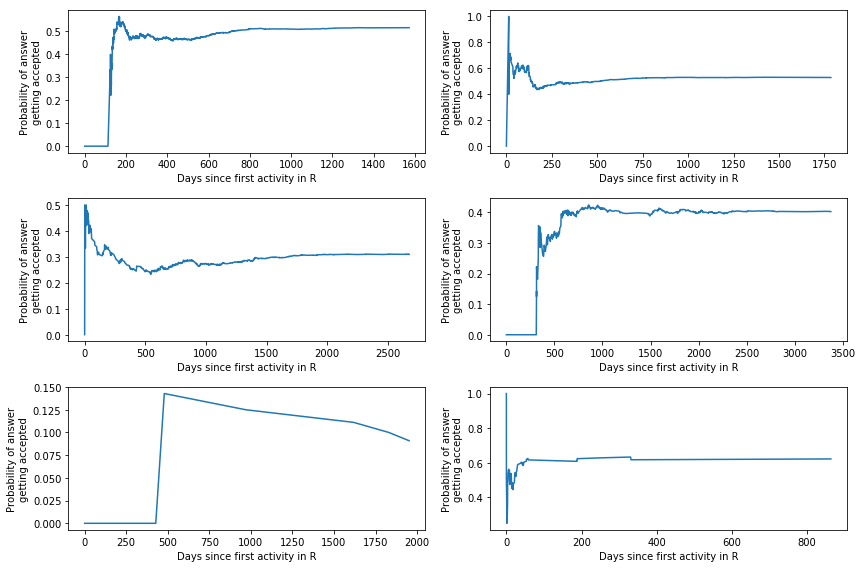

In [95]:
plotEvolutionRandomUsers(RsummaryTableProbAccAnswer,"R")

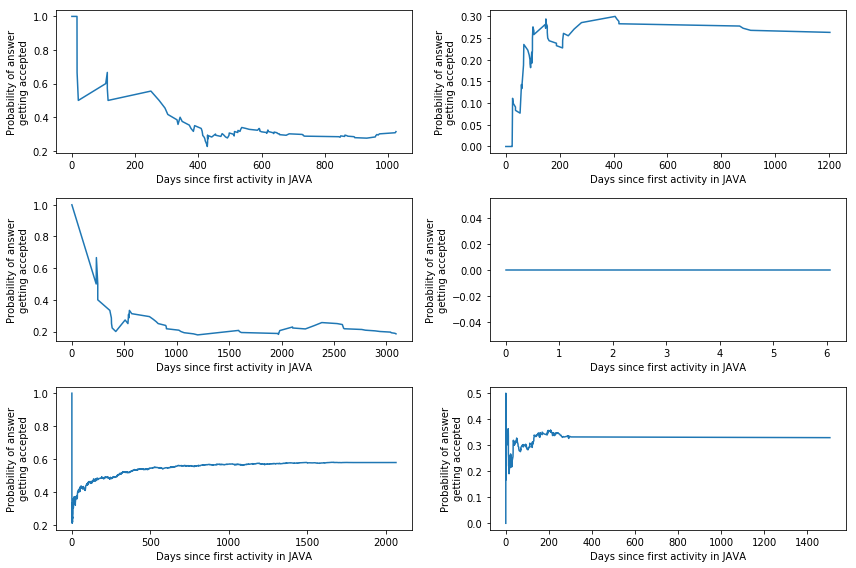

In [96]:
plotEvolutionRandomUsers(JAVAsummaryTableProbAccAnswer,"JAVA")

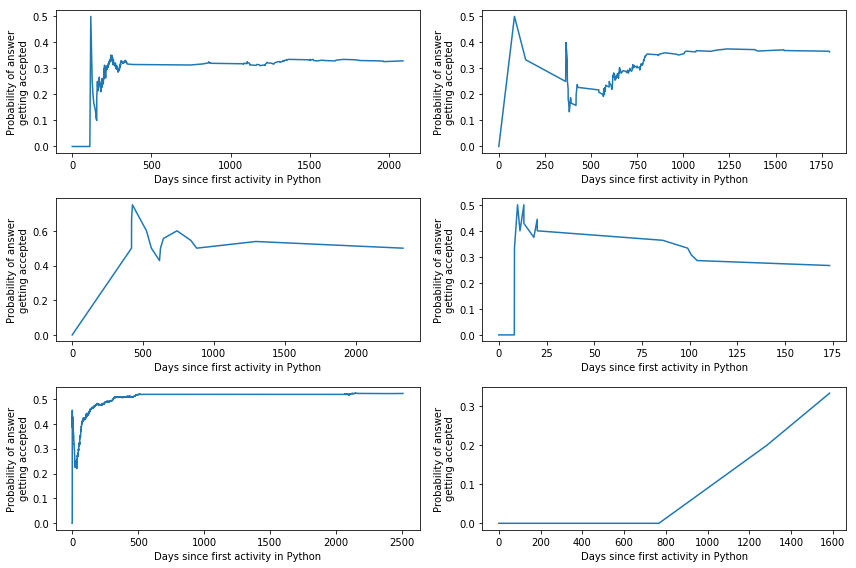

In [97]:
plotEvolutionRandomUsers(PYTsummaryTableProbAccAnswer,"Python")

## Task 7 - Aggregation of all individual learning curves into one 

In [98]:
#Import some modules
import numpy as np
from scipy.interpolate import interp1d

In [99]:
def aggregateIndividualLearningCurves(summaryTableProbAccAnswer,thresExpertise,threshUsers):
    #possible timepoints from 0 to the maximum span.
    x_all = np.linspace(0, max(summaryTableProbAccAnswer["DifferenceDenominator"]),num=5000, endpoint=True)
    
    #variable initialization
    sumProbs = np.zeros(len(x_all))
    nrUsers = np.zeros(len(x_all))
    users = list(set(summaryTableProbAccAnswer[" OwnerUserId"].tolist()))
    total = np.empty((len(x_all),len(users),))
    total.fill(np.nan)
    consUsers=0 #considered users
    i=0
    #for each user:
    #linear interpolation - already checked that curve shape is similar to the ones obtained individually
    for user in users:
        xs_user=summaryTableProbAccAnswer["DifferenceNumerator"][summaryTableProbAccAnswer[" OwnerUserId"]==user].tolist()
        probs_user= summaryTableProbAccAnswer["ProbAccAnswer"][summaryTableProbAccAnswer[" OwnerUserId"]==user].tolist()
        
        #interpolation function for this user
        f1 = interp1d(xs_user,probs_user ,'linear')
        
        # only interpolated values are considered, meaning no extrapolated values
        subset_x_all=x_all[x_all<max(xs_user)]
        f1_int = f1(subset_x_all)
    
        
        # only users that are considered to achieve expertise will be taken into consideration for computing the learning curve
        if (min(probs_user[-5:])>thresExpertise):
            consUsers=consUsers+1
            total[0:len(subset_x_all),i]=f1_int
            #update probability sums at each time point with the interpolated probabilities for this user
            sumProbs[0:len(subset_x_all)]=sumProbs[0:len(subset_x_all)]+f1_int
            #update nr users 
            nrUsers[0:len(subset_x_all)] = nrUsers[0:len(subset_x_all)]+1
            i=i+1

    
    #Remove timepoints which have less than a threshold number of users
    noUsersPos = np.where(nrUsers>threshUsers)
    sumProbs=sumProbs[noUsersPos]
    nrUsers=nrUsers[noUsersPos]
    x_all=x_all[noUsersPos]
    total = total[noUsersPos,:]
    probs=sumProbs/nrUsers
    
    print((len(users)-consUsers)/len(users), " were not considered")
    print (consUsers, " were considered in total")
    
    return([x_all,probs,total,nrUsers])

def plotAvgCurve(x_all,probs,total,nrUsers,language):    
    plt.figure()
    plt.xlabel("Days since first activity in " + language)
    plt.ylabel("Probability of answer\ngetting accepted")
    err=np.sqrt(np.nanvar(total[0],axis=1))/np.sqrt(np.array(nrUsers))
    plt.plot(x_all, probs)
    plt.fill_between(x_all,probs-err,probs+err,alpha=0.5)
    plt.show()
    

0.0  were not considered
5063  were considered in total


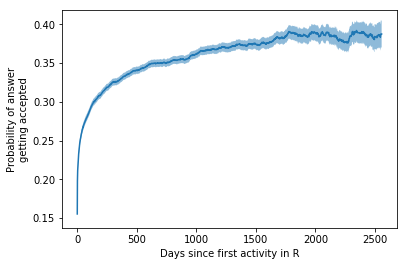

In [ ]:
#R
[Rx_all,Rprobs,Rtotal,RnrUsers]=aggregateIndividualLearningCurves(RsummaryTableProbAccAnswer,-0.1,100)
plotAvgCurve(Rx_all,Rprobs,Rtotal,RnrUsers,"R")

In [ ]:
#JAVA 
[Jx_all,Jprobs,Jtotal,JnrUsers]=aggregateIndividualLearningCurves(JAVAsummaryTableProbAccAnswer,-0.1,100)
plotAvgCurve(Jx_all,Jprobs,Jtotal,JnrUsers,"JAVA")


In [ ]:
#Python
[Px_all,Pprobs,Ptotal,PnrUsers]=aggregateIndividualLearningCurves(PYTsummaryTableProbAccAnswer,-0.1,100)
plotAvgCurve(Px_all,Pprobs,Ptotal,PnrUsers,"Python")

In [ ]:
#All curves in the same plot
plt.figure()
plt.xlabel("Days since first activity")
plt.ylabel("Probability of answer\ngetting accepted")
rpl,=plt.plot(Rx_all, Rprobs,label="R")
err=np.sqrt(np.nanvar(Rtotal[0],axis=1))/np.sqrt(np.array(RnrUsers))
plt.fill_between(Rx_all,Rprobs-err,Rprobs+err,alpha=0.5)

jpl,=plt.plot(Jx_all, Jprobs,label="JAVA")
err=np.sqrt(np.nanvar(Jtotal[0],axis=1))/np.sqrt(np.array(JnrUsers))
plt.fill_between(Jx_all,Jprobs-err,Jprobs+err,alpha=0.5)
ppl,=plt.plot(Px_all, Pprobs,label="Python")
err=np.sqrt(np.nanvar(Ptotal[0],axis=1))/np.sqrt(np.array(PnrUsers))
plt.fill_between(Px_all,Pprobs-err,Pprobs+err,alpha=0.5)
plt.legend(handles=[rpl,jpl,ppl])
plt.show()

In [ ]:
# With normalization
def normProbs (probs):
    maxProb = np.max(probs)
    return probs/maxProb

normRprobs = normProbs(Rprobs)
normJprobs = normProbs(Jprobs)
normPprobs = normProbs(Pprobs)

In [ ]:
#All curves in the same plot
plt.figure()
plt.xlabel("Days since first activity")
plt.ylabel("Probability of answer\ngetting accepted")
rpl,=plt.plot(Rx_all, normRprobs,label="R")
err=np.sqrt(np.nanvar(Rtotal[0],axis=1))/np.sqrt(np.array(RnrUsers))
plt.fill_between(Rx_all,Rprobs-err,Rprobs+err,alpha=0.5)

jpl,=plt.plot(Jx_all, normJprobs,label="JAVA")
err=np.sqrt(np.nanvar(Jtotal[0],axis=1))/np.sqrt(np.array(JnrUsers))
plt.fill_between(Jx_all,Jprobs-err,Jprobs+err,alpha=0.5)
ppl,=plt.plot(Px_all, normPprobs,label="Python")
err=np.sqrt(np.nanvar(Ptotal[0],axis=1))/np.sqrt(np.array(PnrUsers))
plt.fill_between(Px_all,Pprobs-err,Pprobs+err,alpha=0.5)
plt.legend(handles=[rpl,jpl,ppl])
plt.show()

# Modeling

In [29]:
import lmfit

In [30]:
#Models Explored
def negExpo(t,S0,M,lbda):
    return S0 + (M-S0)*(1-np.exp(-lbda*t))

def negExpoModif(t,S0,M,lbda,k):
    return S0 + (M-S0)*(1-np.exp(-lbda*t))+k*t

def powerLaw (t,b,a,c):
    return c+np.power(b*t,a)

def logarithmic(t,c,a):
    return c+a*np.log(t+1)

In [31]:
#Model Fitting
def modelsFitting(x_all,probs,meth,i_S0,i_M,i_lbd,i_k,i_b,i_a,i_c,i_la,i_lc):
    #negExpo
    modelNegExpo =lmfit.Model(negExpo,independent_vars=["t"])
    resultNegExpo = modelNegExpo.fit(np.array(probs),t=np.array(x_all),S0=i_S0,M=i_M,lbda=i_lbd,method=meth)

    #negExpo 
    modelNegExpoModif =lmfit.Model(negExpoModif,independent_vars=["t"])
    resultNegExpoModif = modelNegExpoModif.fit(np.array(probs),t=np.array(x_all),S0=i_S0,M=i_M,lbda=i_lbd,k=i_k,method=meth)

    #powerLaw
    modelPowerLaw=lmfit.Model(powerLaw,independent_vars=["t"])
    resultPowerLaw = modelPowerLaw.fit(np.array(probs),t=np.array(x_all),b=i_b,a=i_a,c=i_c,method=meth,nan_policy='omit')

    #logarithmic
    modelLog=lmfit.Model(logarithmic,independent_vars=["t"])
    resultLog = modelLog.fit(np.array(probs),t=np.array(x_all),a=i_la,c=i_lc,method=meth) 

    return([resultNegExpo,resultNegExpoModif,resultPowerLaw,resultLog])

In [32]:
#plotting model - Experiments
def plotExperiments(x_all,probs,language,i_S0,i_M,i_lbd,i_k,i_b,i_a,i_c,i_la,i_lc):
    plt.figure(figsize=(12,8))
    plt.subplot(2,2,1)
    plt.plot(x_all,probs)
    plt.plot(x_all,negExpo(t=x_all,S0=i_S0,M=i_M,lbda=i_lbd))
    plt.title("Negative Exponential - "+language)

    plt.subplot(2,2,2)
    plt.plot(x_all,probs)
    plt.plot(x_all,negExpoModif(t=x_all,S0=i_S0,M=i_M,lbda=i_lbd,k=i_k))
    plt.title("Negative Exponential Modified - "+language)

    plt.subplot(2,2,3)
    plt.plot(x_all,probs)
    plt.plot(x_all,powerLaw(t=x_all,b=i_b,a=i_a,c=i_c))
    plt.title("Power Law - "+language)

    plt.subplot(2,2,4)
    plt.plot(x_all,probs)
    plt.plot(x_all,logarithmic(t=x_all,a=i_la,c=i_lc))
    plt.title("Logarithmic - "+language)
    plt.show()


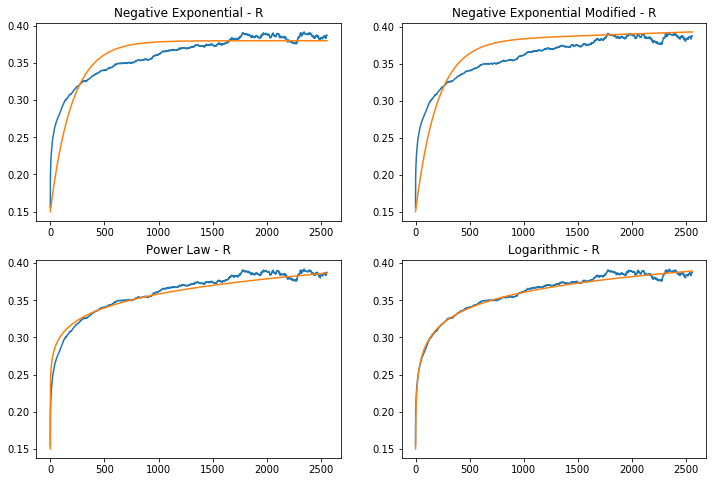

In [33]:
plotExperiments(Rx_all,Rprobs,"R",0.15,0.38,0.005,0.000005,0.000000009,.135,.15,.0305,.15)

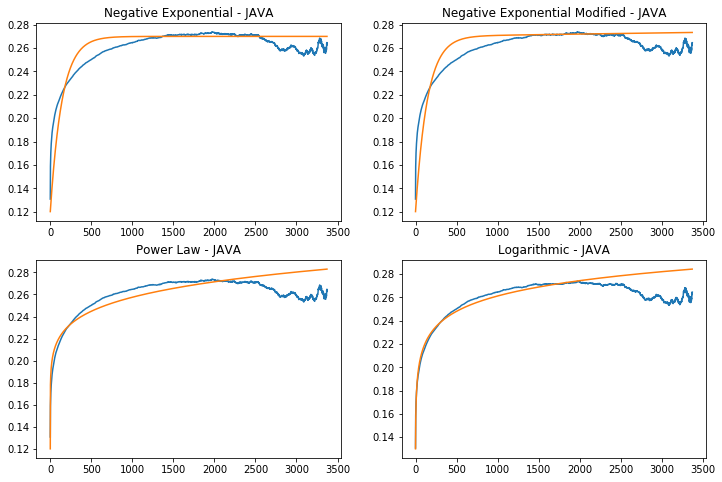

In [34]:
#bad fit with all - JAVA
plotExperiments(Jx_all,Jprobs,"JAVA",0.12,0.27,0.007,0.000001,0.0000000007,.14,.12,.019,.13)

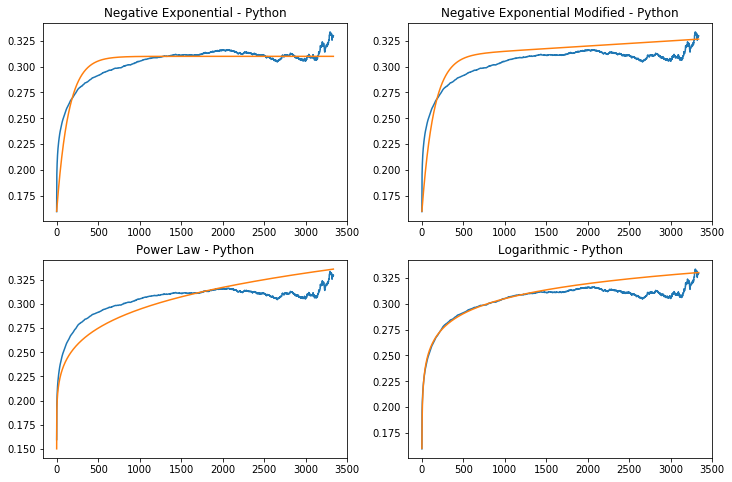

In [35]:
#bad fit with all, same problem- PYTHON
plotExperiments(Px_all,Pprobs,"Python",0.16,0.31,0.007,0.000005,0.0000001,.21,.15,.021,.16)

In [36]:
def plotModelResults (x_all,probs,language,i_S0,i_M,i_lbd,i_k,i_b,i_a,i_c,i_la,i_lc):
    #Compare model with data
    [resultNegExpo,resultNegExpoModif,resultPowerLaw,resultLog] = modelsFitting(x_all,probs,"leastsq",i_S0,i_M,i_lbd,i_k,i_b,i_a,i_c,i_la,i_lc)
    # Least Squares Optimization
    plt.figure(figsize=(12,8))
    plt.subplot(2,2,1)
    #plotting model - Negative Exponential
    plt.plot(x_all,probs)
    plt.plot(x_all,negExpo(t=x_all,**resultNegExpo.values))
    plt.title("Negative Exponential- "+language)

    plt.subplot(2,2,2)
    #plotting model - Negative Exponential Modified
    plt.plot(x_all,probs)
    plt.plot(x_all,negExpoModif(t=x_all,**resultNegExpoModif.values))
    plt.title("Negative Exponential Modified- "+language)

    plt.subplot(2,2,3)
    #plotting model - PowerLaw
    plt.plot(x_all,probs)
    plt.plot(x_all,powerLaw(t=x_all,**resultPowerLaw.values))
    plt.title("Power Law- "+language)

    plt.subplot(2,2,4)
    #plotting model - Logarithmic
    plt.plot(x_all,probs)
    plt.plot(x_all,logarithmic(t=x_all,**resultLog.values))
    plt.title("Logarithmic- "+language)
    plt.show
    
    #Print Goodness of fit
    #Assess Goodness of fit
    print(resultNegExpo.fit_report(min_correl=0.25))
    print(resultNegExpoModif.fit_report(min_correl=0.25))
    print(resultPowerLaw.fit_report(min_correl=0.25))
    print(resultLog.fit_report(min_correl=0.25))

[[Model]]
    Model(negExpo)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 3693
    # variables        = 3
    chi-square         = 0.15397969
    reduced chi-square = 4.1729e-05
    Akaike info crit   = -37238.3815
    Bayesian info crit = -37219.7389
[[Variables]]
    S0:    0.26271585 +/- 5.0341e-04 (0.19%) (init = 0.15)
    M:     0.38516629 +/- 2.1403e-04 (0.06%) (init = 0.38)
    lbda:  0.00190121 +/- 1.6024e-05 (0.84%) (init = 0.005)
[[Correlations]] (unreported correlations are < 0.250)
    C(M, lbda)  = -0.765
    C(S0, lbda) = -0.703
    C(S0, M)    =  0.365

[[Model]]
    Model(negExpoModif)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 48
    # data points      = 3693
    # variables        = 4
    chi-square         = 0.09611789
    reduced chi-square = 2.6055e-05
    Akaike info crit   = -38976.6902
    Bayesian info crit = -38951.8334
[[Variables]]
    S0:    0.24090951 +/- 6.1095e-

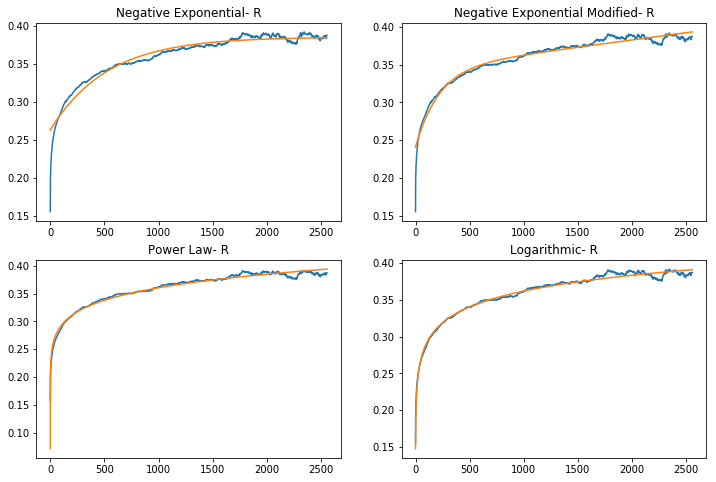

In [37]:
plotModelResults(Rx_all,Rprobs,"R",0.15,0.38,0.005,0.000005,0.000000009,.135,.15,.0305,.15)

[[Model]]
    Model(negExpo)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 27
    # data points      = 3500
    # variables        = 3
    chi-square         = 0.02519820
    reduced chi-square = 7.2057e-06
    Akaike info crit   = -41439.2534
    Bayesian info crit = -41420.7718
[[Variables]]
    S0:    0.18958435 +/- 2.4830e-04 (0.13%) (init = 0.12)
    M:     0.27144119 +/- 6.8814e-05 (0.03%) (init = 0.27)
    lbda:  0.00283851 +/- 1.5041e-05 (0.53%) (init = 0.007)
[[Correlations]] (unreported correlations are < 0.250)
    C(S0, lbda) = -0.699
    C(M, lbda)  = -0.625
    C(S0, M)    =  0.269

[[Model]]
    Model(negExpoModif)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 48
    # data points      = 3500
    # variables        = 4
    chi-square         = 0.02132806
    reduced chi-square = 6.1007e-06
    Akaike info crit   = -42020.8744
    Bayesian info crit = -41996.2324
[[Variables]]
    S0:    0.18569618 +/- 2.7056e-

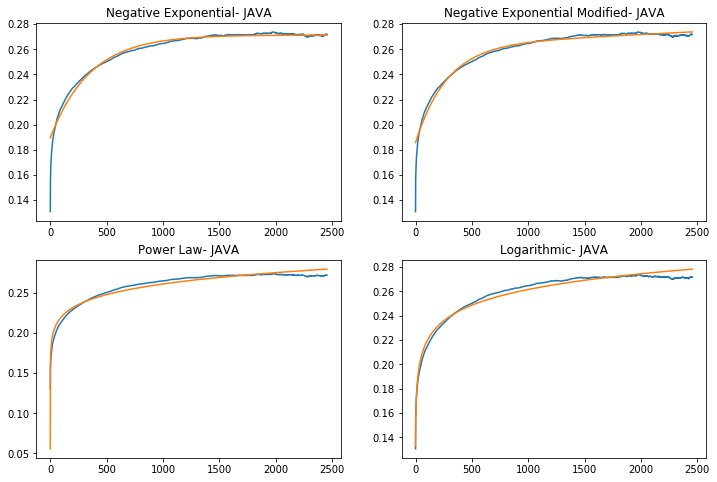

In [38]:
plotModelResults(Jx_all[0:3500],Jprobs[0:3500],"JAVA",0.12,0.27,0.007,0.000001,0.0000000007,.14,.12,.02,.12)

[[Model]]
    Model(negExpo)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 3500
    # variables        = 3
    chi-square         = 0.04267069
    reduced chi-square = 1.2202e-05
    Akaike info crit   = -39595.6640
    Bayesian info crit = -39577.1825
[[Variables]]
    S0:    0.23011743 +/- 3.2391e-04 (0.14%) (init = 0.16)
    M:     0.31243038 +/- 8.9247e-05 (0.03%) (init = 0.31)
    lbda:  0.00285469 +/- 1.9590e-05 (0.69%) (init = 0.007)
[[Correlations]] (unreported correlations are < 0.250)
    C(S0, lbda) = -0.699
    C(M, lbda)  = -0.623
    C(S0, M)    =  0.268

[[Model]]
    Model(negExpoModif)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 53
    # data points      = 3500
    # variables        = 4
    chi-square         = 0.02864031
    reduced chi-square = 8.1923e-06
    Akaike info crit   = -40989.1043
    Bayesian info crit = -40964.4622
[[Variables]]
    S0:    0.22099777 +/- 3.4650e-

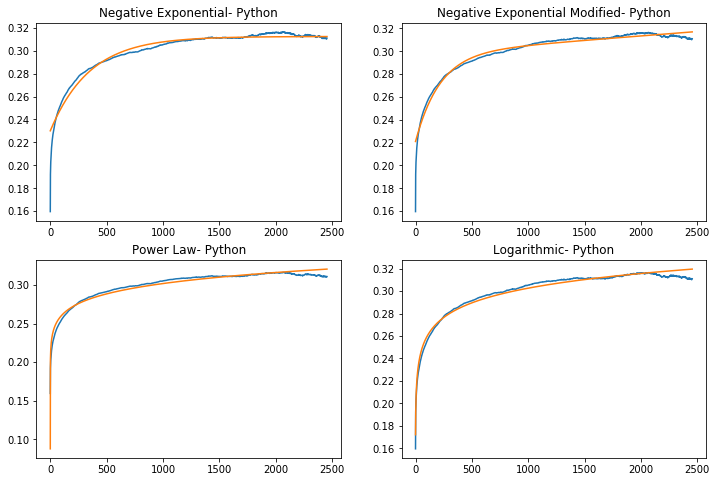

In [39]:
plotModelResults(Px_all[0:3500],Pprobs[0:3500],"Python",0.16,0.31,0.007,0.000005,0.0000001,.21,.15,.020,.15)